<a href="https://colab.research.google.com/github/Preetish2603/SVM--Assignment-5--UCS654/blob/main/svm_final_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...

===== Dataset Information =====
Dataset shape: (20000, 17)
Number of classes: 26
Number of features: 16

===== Class Distribution =====
letter
A    789
B    766
C    736
D    805
E    768
F    775
G    773
H    734
I    755
J    747
K    739
L    761
M    792
N    783
O    753
P    803
Q    783
R    758
S    748
T    796
U    813
V    764
W    752
X    787
Y    786
Z    734
Name: count, dtype: int64

===== Feature Statistics =====
              x-box         y-box         width       height         onpix  \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
mean       4.023550      7.035500      5.121850      5.37245      3.505850   
std        1.913212      3.304555      2.014573      2.26139      2.190458   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%        3.000000      5.000000      4.000000      4.00000      2.000000   
50%        4.000000      7.000000      5.000000      6.00000      3.000000   

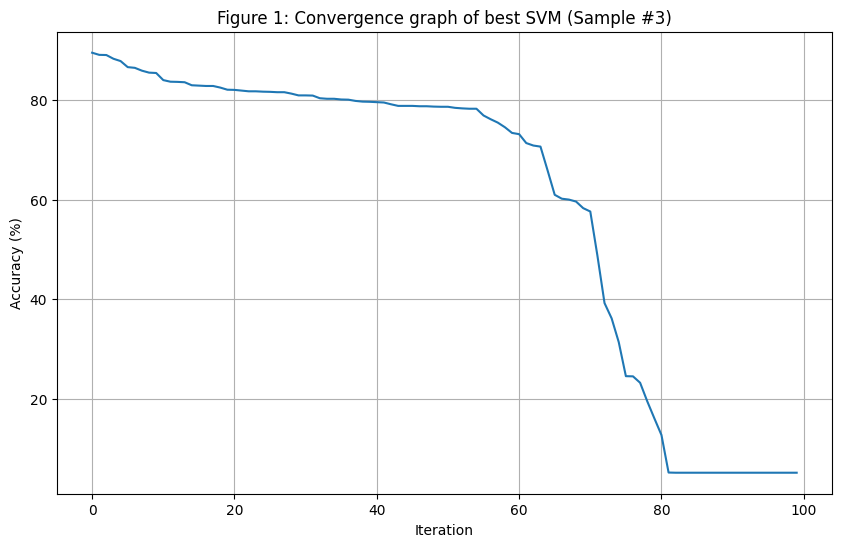


===== Detailed Analysis for Best Model (Sample #3) =====
Best parameters: Kernel=rbf, Nu=75.904, Epsilon=0.08337
Best cross-validation accuracy: 89.50%
Test accuracy: 97.02%

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.99      0.99       224
           B       0.93      0.97      0.95       226
           C       0.95      0.96      0.96       212
           D       0.94      0.97      0.95       238
           E       0.95      0.96      0.96       231
           F       0.97      0.97      0.97       250
           G       0.95      0.98      0.96       249
           H       0.90      0.90      0.90       235
           I       0.98      0.98      0.98       233
           J       0.97      0.97      0.97       214
           K       0.96      0.95      0.96       220
           L       0.99      0.97      0.98       240
           M       0.99      0.98      0.99       220
           N       0.98      0.97      0.98 

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import loguniform
import warnings
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

# ========================
# 1. Data Loading & Basic Analytics
# ========================

# Load dataset
print("Loading dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
columns = ['letter', 'x-box', 'y-box', 'width', 'height', 'onpix', 'x-bar',
           'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege',
           'xegvy', 'y-ege', 'yegvx']
data = pd.read_csv(url, header=None, names=columns)

# Basic dataset analytics
print("\n===== Dataset Information =====")
print(f"Dataset shape: {data.shape}")
print(f"Number of classes: {data['letter'].nunique()}")
print(f"Number of features: {len(data.columns) - 1}")

# Display class distribution
print("\n===== Class Distribution =====")
class_counts = data['letter'].value_counts().sort_index()
print(class_counts)

# Display basic statistics of features
print("\n===== Feature Statistics =====")
feature_stats = data.drop('letter', axis=1).describe()
print(feature_stats)

# Visualization of class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='letter', data=data)
plt.title('Class Distribution in Letter Recognition Dataset')
plt.xlabel('Letter')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.close()

# Feature correlation analysis
plt.figure(figsize=(12, 10))
correlation = data.drop('letter', axis=1).corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.savefig('feature_correlation.png')
plt.close()

# Convert letters to numerical labels
le = LabelEncoder()
data['label'] = le.fit_transform(data['letter'])

# Split features and target
X = data.drop(['letter', 'label'], axis=1)
y = data['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ========================
# 2. Create 10 Data Splits - Ensure numpy arrays
# ========================

splits = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=i
    )
    # Ensure y_train is a numpy array, not a pandas Series
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()
    if isinstance(y_test, pd.Series):
        y_test = y_test.to_numpy()

    splits.append((X_train, X_test, y_train, y_test))

# ========================
# 3. SVM Optimization with 100 iterations
# ========================

# Define parameter space
param_dist = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': loguniform(1e0, 1e2),  # This corresponds to Nu in assignment table
    'gamma': loguniform(1e-4, 1e-1)  # This corresponds to Epsilon in assignment table
}

# Function to process a single sample
def process_sample(sample_num):
    print(f"Processing Sample #{sample_num+1}")
    X_train, X_test, y_train, y_test = splits[sample_num]

    # Use a subset of training data for hyperparameter search
    subset_size = min(3000, int(len(X_train) * 0.2))

    # Generate indices for the subset
    indices = np.random.choice(len(X_train), subset_size, replace=False)

    # Create subset using numpy array indexing (not pandas indexing)
    X_train_subset = X_train[indices]
    y_train_subset = y_train[indices]  # This should work now that y_train is a numpy array

    # Run randomized search with 100 iterations as required by assignment
    search = RandomizedSearchCV(
        SVC(),
        param_distributions=param_dist,
        n_iter=100,  # Using 100 iterations as per assignment requirements
        cv=3,
        random_state=42,
        verbose=0
    )
    search.fit(X_train_subset, y_train_subset)

    # Get the best model and refit on full training data
    best_model = SVC(**search.best_params_)
    best_model.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred) * 100

    return {
        'Sample #': f"S{sample_num+1}",
        'Best Accuracy': f"{search.best_score_ * 100:.2f}%",
        'Test Accuracy': f"{test_acc:.2f}%",
        'Kernel': search.best_params_['kernel'],
        'Nu': f"{search.best_params_['C']:.3f}",  # Renamed to Nu per assignment table
        'Epsilon': f"{search.best_params_['gamma']:.5f}",  # Renamed to Epsilon per assignment table
        'cv_results': search.cv_results_,
        'model': best_model,
        'y_test': y_test,
        'y_pred': y_pred
    }

# Process samples in parallel with fewer jobs to avoid memory issues
print("\n===== Starting SVM Optimization =====")
print("This will take some time with 100 iterations...")
results = Parallel(n_jobs=2)(delayed(process_sample)(i) for i in range(10))

# Find the best sample
max_accuracy = 0
best_sample_data = None
for i, result in enumerate(results):
    acc = float(result['Best Accuracy'].strip('%'))
    if acc > max_accuracy:
        max_accuracy = acc
        best_sample_data = result
        best_sample_data['sample_num'] = i+1

# ========================
# 4. Results Display and Visualization
# ========================

# Print results table
print("\n===== Table 1: Comparative performance of Optimized-SVM with different samples =====")
result_df = pd.DataFrame([{
    'Sample #': result['Sample #'],
    'Best Accuracy': result['Best Accuracy'],
    'Best SVM Parameters\nKernel, Nu, Epsilon': f"{result['Kernel']}, {result['Nu']}, {result['Epsilon']}"
} for result in results])
print(result_df)

# Plot convergence graph for best sample
if best_sample_data:
    plt.figure(figsize=(10, 6))
    cv_results = best_sample_data['cv_results']

    # Sort by mean_test_score in descending order for convergence plot
    sorted_indices = np.argsort(cv_results['mean_test_score'])[::-1]
    sorted_scores = [cv_results['mean_test_score'][i] * 100 for i in sorted_indices]

    plt.plot(range(len(sorted_scores)), sorted_scores)
    plt.title(f"Figure 1: Convergence graph of best SVM (Sample #{best_sample_data['sample_num']})")
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.savefig('convergence_plot.png')
    plt.show()

    # Additional analysis for best model
    print(f"\n===== Detailed Analysis for Best Model (Sample #{best_sample_data['sample_num']}) =====")
    print(f"Best parameters: Kernel={best_sample_data['Kernel']}, Nu={best_sample_data['Nu']}, Epsilon={best_sample_data['Epsilon']}")
    print(f"Best cross-validation accuracy: {best_sample_data['Best Accuracy']}")
    print(f"Test accuracy: {best_sample_data['Test Accuracy']}")

    # Convert numeric predictions back to letters for interpretability
    y_test_letters = le.inverse_transform(best_sample_data['y_test'])
    y_pred_letters = le.inverse_transform(best_sample_data['y_pred'])

    # Generate confusion matrix for top confusions
    conf_matrix = confusion_matrix(y_test_letters, y_pred_letters)
    plt.figure(figsize=(14, 12))
    sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
                xticklabels=sorted(data['letter'].unique()),
                yticklabels=sorted(data['letter'].unique()))
    plt.title('Confusion Matrix for Best SVM Model')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # Generate classification report
    class_report = classification_report(y_test_letters, y_pred_letters)
    print("\nClassification Report:")
    print(class_report)

print("\nAnalysis complete! Results saved as PNG files.")
